In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# print all columns 
pd.set_option('display.max_columns', None)

# Import Data

In [2]:
data = pd.read_csv('../DataOut/bus_trip_speed_and_other_features.csv')
# import bus trips
bus_trips = pd.read_csv("../DataOut/bus_trips.csv")

# load the csv Data Sets\route points.csv 
route_points = pd.read_csv("../Data Sets/route points.csv")

In [3]:
data

,deviceid,devicetime,latitude,longitude,speed,date,time,bus_stop,trip_id,direction,acceleration,radial_acceleration,distance_from_start,time_diff,acc_diff,acceleration_der,segment
0,116,2021-10-16 08:03:19,7.293068,80.636430,14.03890,2021-10-16,08:03:19,0,2.0,1,0.323975,0.000000,0.000000,NaN,NaN,0.000000,1
1,116,2021-10-16 08:03:34,7.293043,80.637552,10.25920,2021-10-16,08:03:34,0,2.0,1,-0.251980,1.278067,123.738485,0 days 00:00:15,-0.575955,-0.038397,1
2,116,2021-10-16 08:03:49,7.292725,80.637707,7.55940,2021-10-16,08:03:49,0,2.0,1,-0.179987,0.722300,163.044397,0 days 00:00:15,0.071993,0.004800,1
3,116,2021-10-16 08:04:04,7.292292,80.637663,3.77970,2021-10-16,08:04:04,0,2.0,1,-0.251980,0.048332,211.472339,0 days 00:00:15,-0.071993,-0.004800,1
4,116,2021-10-16 08:04:19,7.291640,80.637455,9.17927,2021-10-16,08:04:19,101,2.0,1,0.359971,1.052222,287.492821,0 days 00:00:15,0.611951,0.040797,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034419,1719,2022-02-25 16:47:53,7.291572,80.635452,2.15983,2022-02-25,16:47:53,0,15890.0,2,0.215983,0.714925,16242.694984,0 days 00:00:10,2.105833,0.210583,0
4034420,1719,2022-02-25 16:47:57,7.291587,80.635355,2.15983,2022-02-25,16:47:57,0,15890.0,2,0.000000,0.003500,16253.479312,0 days 00:00:04,-0.215983,-0.053996,0
4034421,1719,2022-02-25 16:48:02,7.291597,80.635293,3.77970,2022-02-25,16:48:02,0,15890.0,2,0.323974,1.320196,16260.374802,0 days 00:00:05,0.323974,0.064795,0
4034422,1719,2022-02-25 16:48:03,7.291605,80.635280,3.77970,2022-02-25,16:48:03,0,15890.0,2,0.000000,0.128080,16262.113859,0 days 00:00:01,-0.323974,-0.323974,0


In [4]:
# detects trips with not enought gps points and removes them
data['count'] = data.groupby('trip_id')['trip_id'].transform('count')
print(data['count'].mean())

# print a complete list of trip ids that count less than 50
print(data[data['count'] < 50]['trip_id'].unique())
# drop trips with less than 50 gps points
data = data[data['count'] > 50].copy()

607.25928856263
[]


## prepare data

In [5]:
#  date is do we will not include testing data in the clustering
data_selected=data[data['date']<'2022-10-01'].copy()
data_test_selected=data[data['date']>='2022-10-01'].copy()

data_to_cluster=data_selected[['trip_id','deviceid','segment','speed','acceleration','radial_acceleration','acceleration_der']]
data_to_test=data_test_selected[['trip_id','deviceid','segment','speed','acceleration','radial_acceleration','acceleration_der']]

# reset index
data_to_cluster=data_to_cluster.reset_index(drop=True)
data_to_test=data_to_test.reset_index(drop=True)

# data_to_cluster drop rows where segment is 0
data_to_cluster=data_to_cluster[data_to_cluster['segment']!=0].copy()
data_to_test=data_to_test[data_to_test['segment']!=0].copy()

In [6]:
data_to_cluster

,trip_id,deviceid,segment,speed,acceleration,radial_acceleration,acceleration_der
0,2.0,116,1,14.03890,0.323975,0.000000,0.000000
1,2.0,116,1,10.25920,-0.251980,1.278067,-0.038397
2,2.0,116,1,7.55940,-0.179987,0.722300,0.004800
3,2.0,116,1,3.77970,-0.251980,0.048332,-0.004800
4,2.0,116,1,9.17927,0.359971,1.052222,0.040797
...,...,...,...,...,...,...,...
3559552,15890.0,1719,34,7.55940,-0.359970,0.286957,-0.479960
3559553,15890.0,1719,34,7.01944,-0.269980,1.196474,0.044995
3559554,15890.0,1719,34,5.39957,-0.809935,1.022045,-0.269978
3559555,15890.0,1719,34,5.39957,0.000000,0.938451,0.404968


In [7]:
# set Nan in bus_stop to 0
data['bus_stop']=data['bus_stop'].fillna(0)
data_selected['bus_stop']=data_selected['bus_stop'].fillna(0)
data_test_selected['bus_stop']=data_test_selected['bus_stop'].fillna(0)

In [8]:
Cols_for_clusteringDF=['devicetime', 'radial_acceleration','speed', 'acceleration','distance_from_start','acceleration_der','bus_stop']

# Clustering

In [9]:
Dict_of_clusters = {}

# Normal Cluster

In [10]:
features_only_df = data_to_cluster[['speed', 'acceleration', 'radial_acceleration','acceleration_der']]

features_only_df_test = data_to_test[['speed', 'acceleration', 'radial_acceleration','acceleration_der']]

In [11]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # Assuming you have your preprocessed data in 'data_to_cluster_mean'

# # List to store distortion values
# distortions = []

# # Choose a range of cluster counts to try
# cluster_range = range(1, 11)

# # Calculate distortion for each cluster count
# for num_clusters in cluster_range:
#     kmeans = KMeans(n_clusters=num_clusters, random_state=0)
#     kmeans.fit(features_only_df)
#     distortions.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# # Plot the elbow curve
# plt.plot(cluster_range, distortions, marker='o')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Distortion')
# plt.title('Elbow Method')
# plt.show()

In [12]:
features_only_df

,speed,acceleration,radial_acceleration,acceleration_der
0,14.03890,0.323975,0.000000,0.000000
1,10.25920,-0.251980,1.278067,-0.038397
2,7.55940,-0.179987,0.722300,0.004800
3,3.77970,-0.251980,0.048332,-0.004800
4,9.17927,0.359971,1.052222,0.040797
...,...,...,...,...
3559552,7.55940,-0.359970,0.286957,-0.479960
3559553,7.01944,-0.269980,1.196474,0.044995
3559554,5.39957,-0.809935,1.022045,-0.269978
3559555,5.39957,0.000000,0.938451,0.404968


In [13]:
# # min max scaler for features_only_df
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# features_only_df = scaler.fit_transform(features_only_df)
# features_only_df_test = scaler.fit_transform(features_only_df_test)

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Choose the number of clusters
num_clusters = 3

# Initialize the clustering algorithm
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Fit the algorithm to your data
kmeans.fit(features_only_df)

# Get cluster assignments for each data point
cluster_labels = kmeans.labels_

# Get cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

# Add cluster labels to your original dataset
data_with_clusters = pd.DataFrame(features_only_df, columns=['speed', 'acceleration', 'radial_acceleration','acceleration_der'])
data_with_clusters['cluster'] = cluster_labels
data_with_clusters['deviceid'] = data_to_cluster['deviceid']  # Add 'deviceid' column from data_to_cluster
data_with_clusters['trip_id'] = data_to_cluster['trip_id']  
data_with_clusters['segment'] = data_to_cluster['segment']

c:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
# get the cluster values for features_only_df_test using the kmeans model 
cluster_labels_test = kmeans.predict(features_only_df_test)

# Add cluster labels to your original dataset
data_with_clusters_test = pd.DataFrame(features_only_df_test, columns=['speed', 'acceleration', 'radial_acceleration','acceleration_der'])
data_with_clusters_test['cluster'] = cluster_labels_test
data_with_clusters_test['deviceid'] = data_to_test['deviceid']  # Add 'deviceid' column from data_to_cluster
data_with_clusters_test['trip_id'] = data_to_test['trip_id']
data_with_clusters_test['segment'] = data_to_test['segment']
data_with_clusters_test

,speed,acceleration,radial_acceleration,acceleration_der,cluster,deviceid,trip_id,segment
0,16.19870,0.647948,0.000000,0.000000,1,116,847.0,1
1,12.41900,-0.251980,0.150614,-0.059995,2,116,847.0,1
2,7.01944,-0.359971,0.975715,-0.007199,2,116,847.0,1
3,9.17927,0.143989,0.294434,0.033597,2,116,847.0,1
4,2.69978,-0.431966,0.043629,-0.038397,0,116,847.0,1
...,...,...,...,...,...,...,...,...
474847,11.87910,-0.287973,0.336375,-0.021598,2,1377,14367.0,34
474848,16.19870,0.287973,0.329089,0.038396,1,1377,14367.0,34
474849,12.41900,-0.251980,0.412003,-0.035997,2,1377,14367.0,34
474850,29.15770,1.195621,1.889283,0.103400,1,1377,14367.0,34


In [16]:
# concatanate data_with_clusters and data_with_clusters_test
data_with_clusters_all=pd.concat([data_with_clusters,data_with_clusters_test])
data_with_clusters_all

,speed,acceleration,radial_acceleration,acceleration_der,cluster,deviceid,trip_id,segment
0,14.03890,0.323975,0.000000,0.000000,2,116,2.0,1
1,10.25920,-0.251980,1.278067,-0.038397,2,116,2.0,1
2,7.55940,-0.179987,0.722300,0.004800,2,116,2.0,1
3,3.77970,-0.251980,0.048332,-0.004800,0,116,2.0,1
4,9.17927,0.359971,1.052222,0.040797,2,116,2.0,1
...,...,...,...,...,...,...,...,...
474847,11.87910,-0.287973,0.336375,-0.021598,2,1377,14367.0,34
474848,16.19870,0.287973,0.329089,0.038396,1,1377,14367.0,34
474849,12.41900,-0.251980,0.412003,-0.035997,2,1377,14367.0,34
474850,29.15770,1.195621,1.889283,0.103400,1,1377,14367.0,34


In [17]:
data_with_clusters_all

,speed,acceleration,radial_acceleration,acceleration_der,cluster,deviceid,trip_id,segment
0,14.03890,0.323975,0.000000,0.000000,2,116,2.0,1
1,10.25920,-0.251980,1.278067,-0.038397,2,116,2.0,1
2,7.55940,-0.179987,0.722300,0.004800,2,116,2.0,1
3,3.77970,-0.251980,0.048332,-0.004800,0,116,2.0,1
4,9.17927,0.359971,1.052222,0.040797,2,116,2.0,1
...,...,...,...,...,...,...,...,...
474847,11.87910,-0.287973,0.336375,-0.021598,2,1377,14367.0,34
474848,16.19870,0.287973,0.329089,0.038396,1,1377,14367.0,34
474849,12.41900,-0.251980,0.412003,-0.035997,2,1377,14367.0,34
474850,29.15770,1.195621,1.889283,0.103400,1,1377,14367.0,34


In [18]:
Norm_clusters_data=data_with_clusters_all.copy()
import statistics

# Define a custom function to calculate the mode
def select_mode(x):
    if len(x) == 0:
        return None
    elif len(x) == 1:
        return x.iloc[0]  # Return the single mode if there's only one
    else:
        # If there are multiple modes, return one of them
        return statistics.mode(x)

# Apply the custom mode function when aggregating
Norm_clusters_data = Norm_clusters_data.groupby(['trip_id', 'deviceid']).agg({
    'speed': 'mean',
    'acceleration': 'mean',
    'radial_acceleration': 'mean',
    'acceleration_der': 'mean',
    'cluster': select_mode  # Use the custom function to calculate the mode
}).reset_index()

Norm_clusters_vs_tid=Norm_clusters_data[['trip_id','cluster']]
# rename cluster as norm_cluster
Norm_clusters_vs_tid.rename(columns={'cluster':'norm_cluster'}, inplace=True)

C:\Users\gw\AppData\Local\Temp\ipykernel_11680\1600939853.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Norm_clusters_vs_tid.rename(columns={'cluster':'norm_cluster'}, inplace=True)


In [19]:
# cluster average segment vise

seg_cluster=data_with_clusters_all.copy()
import statistics

# Define a custom function to calculate the mode
def select_mode(x):
    if len(x) == 0:
        return None
    elif len(x) == 1:
        return x.iloc[0]  # Return the single mode if there's only one
    else:
        # If there are multiple modes, return one of them
        return statistics.mode(x)

# Apply the custom mode function when aggregating
seg_cluster = seg_cluster.groupby(['trip_id', 'deviceid','segment']).agg({
    'speed': 'mean',
    'acceleration': 'mean',
    'radial_acceleration': 'mean',
    'acceleration_der': 'mean',
    'cluster': select_mode  # Use the custom function to calculate the mode
}).reset_index()

seg_cluster_vs_tid=seg_cluster[['trip_id','segment','cluster']]
# rename cluster as norm_cluster
seg_cluster_vs_tid.rename(columns={'cluster':'norm_cluster'}, inplace=True)

C:\Users\gw\AppData\Local\Temp\ipykernel_11680\3937439333.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_cluster_vs_tid.rename(columns={'cluster':'norm_cluster'}, inplace=True)


In [20]:
seg_cluster_vs_tid

,trip_id,segment,norm_cluster
0,1.0,21,1
1,1.0,22,1
2,1.0,23,1
3,1.0,24,2
4,1.0,25,2
...,...,...,...
193860,15891.0,11,1
193861,15891.0,12,1
193862,15891.0,13,1
193863,15891.0,14,2


# Cluster Vis

In [21]:
# number of each clusetrs in Norm_clusters_vs_tid
seg_cluster_vs_tid['norm_cluster'].value_counts()

norm_cluster
2    72309
0    65102
1    56454
Name: count, dtype: int64

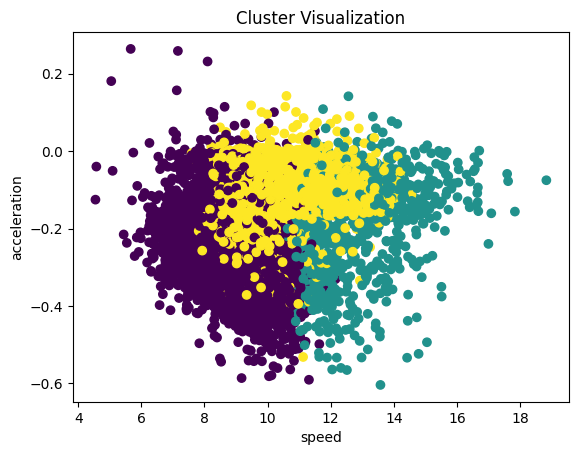

In [22]:
def draw_tid_clusters(data_with_clusters, x_axis, y_axis, cluster_labels, cluster_centers=None):
    # Visualize the clusters (for 2D data)
    plt.scatter(data_with_clusters[x_axis], data_with_clusters[y_axis], c=cluster_labels, cmap='viridis')
    if cluster_centers is not None:
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='red')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title('Cluster Visualization')
    plt.show()

# Make sure 'tid_cluster' is a list or 1D array
tid_cluster = Norm_clusters_data['cluster'].tolist()


# Now, call the draw_clusters function
draw_tid_clusters(Norm_clusters_data, 'speed', 'acceleration', tid_cluster)


In [23]:
Dict_of_clusters['norm_cluster']=Norm_clusters_data

In [24]:
def draw_clusters(data_with_clusters,x_axis,y_axis):
    # Visualize the clusters (for 2D data)
    plt.scatter(data_with_clusters[x_axis], data_with_clusters[y_axis], c=cluster_labels, cmap='viridis')
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, c='red')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title('Cluster Visualization')
    plt.show()


In [25]:
# draw_clusters(data_with_clusters,'deviceid','speed')
# draw_clusters(data_with_clusters,'speed','acceleration')
# draw_clusters(data_with_clusters,'speed','radial_acceleration')
# draw_clusters(data_with_clusters,'speed','acceleration_der')

In [26]:
# import matplotlib.pyplot as plt

# # Calculate average values for each cluster
# average_values = data_with_clusters.groupby('cluster').mean()

# # Plot bar graph for Average Speed
# plt.bar(average_values.index, average_values['speed'])
# plt.xlabel('Cluster')
# plt.ylabel('Average Speed')
# plt.title('Average Speed by Cluster')
# plt.xticks(average_values.index)
# plt.show()

# # Plot bar graph for Average Acceleration
# plt.bar(average_values.index, average_values['acceleration'])
# plt.xlabel('Cluster')
# plt.ylabel('Average Acceleration')
# plt.title('Average Acceleration by Cluster')
# plt.xticks(average_values.index)
# plt.show()

# # Plot bar graph for Average Radial Acceleration
# plt.bar(average_values.index, average_values['radial_acceleration'])
# plt.xlabel('Cluster')
# plt.ylabel('Average Radial Acceleration')
# plt.title('Average Radial Acceleration by Cluster')
# plt.xticks(average_values.index)
# plt.show()


# Cassificaton Modle

In [27]:
# save seg_cluster_vs_tid to csv
seg_cluster_vs_tid.to_csv('../DataOut/seg_cluster_vs_tid.csv', index=False)

In [28]:
bus_running_times_feature_added_all_moddedDF=pd.read_csv('../DataOut/bus_running_times_feature_added_all_moddedDF.csv')

In [29]:
# bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(
#     left=bus_running_times_feature_added_all_moddedDF,
#     right=bus_trip_speed_and_other_features_grpd[['trip_id', 'segment', 'Kmeans_cluster']],
#     on=['trip_id', 'segment']
# ) do a left join like this

# left join bus_running_times_feature_added_all_moddedDF with bus_trip_speed_and_other_features_grpd[['trip_id', 'segment', 'Kmeans_cluster'] on trip_id and segment
bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(
    left=bus_running_times_feature_added_all_moddedDF,
    right=seg_cluster_vs_tid[['trip_id', 'segment', 'norm_cluster']],
    on=['trip_id', 'segment'],
    how='left'
)

bus_running_times_feature_added_all_with_Kmeans_cluster


,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1),norm_cluster
0,4890.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,2.0
1,4890.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,74.0,2.0
2,4890.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,2.0
3,4890.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,6.0,1.0
4,4890.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197627,3462.0,123.0,2.0,28.0,2022-10-31,18:45:44,18:47:23,0:01:39,99.0,0.8700,0.0,18.75,0.0,0,1,42.0,120.0,120.0,120.0,120.0,120.0,63.0,156.0,197.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,9.0,1.0
197628,3462.0,123.0,2.0,29.0,2022-10-31,18:47:38,18:50:23,0:02:45,165.0,1.4000,0.0,18.75,0.0,0,1,42.0,218.0,218.0,218.0,218.0,218.0,99.0,63.0,156.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,15.0,1.0
197629,3462.0,123.0,2.0,30.0,2022-10-31,18:50:56,18:56:33,0:05:37,337.0,2.5600,0.0,18.75,0.0,0,1,42.0,391.0,391.0,391.0,391.0,391.0,165.0,99.0,63.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,33.0,2.0
197630,3462.0,123.0,2.0,31.0,2022-10-31,18:56:48,18:57:34,0:00:46,46.0,0.4200,0.0,18.75,0.0,0,1,42.0,65.0,65.0,65.0,65.0,65.0,337.0,165.0,99.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,15.0,1.0


In [30]:
bus_running_times_feature_added_all_with_Kmeans_cluster.dropna(inplace=True)
bus_running_times_feature_added_all_with_Kmeans_cluster

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1),norm_cluster
0,4890.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,2.0
1,4890.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,74.0,2.0
2,4890.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,2.0
3,4890.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,6.0,1.0
4,4890.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1.0,10.0,20.0,0.0,6.1,Partially cloudy,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197627,3462.0,123.0,2.0,28.0,2022-10-31,18:45:44,18:47:23,0:01:39,99.0,0.8700,0.0,18.75,0.0,0,1,42.0,120.0,120.0,120.0,120.0,120.0,63.0,156.0,197.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,9.0,1.0
197628,3462.0,123.0,2.0,29.0,2022-10-31,18:47:38,18:50:23,0:02:45,165.0,1.4000,0.0,18.75,0.0,0,1,42.0,218.0,218.0,218.0,218.0,218.0,99.0,63.0,156.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,15.0,1.0
197629,3462.0,123.0,2.0,30.0,2022-10-31,18:50:56,18:56:33,0:05:37,337.0,2.5600,0.0,18.75,0.0,0,1,42.0,391.0,391.0,391.0,391.0,391.0,165.0,99.0,63.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,33.0,2.0
197630,3462.0,123.0,2.0,31.0,2022-10-31,18:56:48,18:57:34,0:00:46,46.0,0.4200,0.0,18.75,0.0,0,1,42.0,65.0,65.0,65.0,65.0,65.0,337.0,165.0,99.0,18.0,31.0,10.0,22.2,0.0,4.3,Partially cloudy,15.0,1.0


In [31]:
def prepare(df):
    df['date'] = pd.to_datetime(df['date'])
    df['start_time'] = pd.to_datetime(df['start_time'],
                                    format='%H:%M:%S').dt.time

    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    df.drop(['run_time'], axis=1,inplace = True)
    df.drop(['end_time'], axis=1,inplace = True)

    #replace ' partially cloudy' with 'partially cloudy'
    df['conditions'] = df['conditions'].replace(' Partially cloudy', 'Partially cloudy')


    from sklearn.preprocessing import OrdinalEncoder

    # Replace NaN values in the 'conditions' column with 'Unknown'
    df['conditions'].fillna('Unknown', inplace=True)

    conditions = ['Rain', 'Rain, Overcast', 'Rain, Partially cloudy', 'Overcast', 'Partially cloudy', 'Clear','Unknown']
    encoder = OrdinalEncoder(categories=[conditions])
    df['conditions_encoded'] = encoder.fit_transform(df[['conditions']])

    # Now, you can drop the original 'conditions' column if needed
    df = df.drop(['conditions'], axis=1)

    df['start_float'] = df['start_time'].apply(lambda x: x.hour + x.minute/60.0 + x.second/3600.0)

    # drop 
    df = df.drop(['start_time'], axis=1)

    # Drop the original date column
    df.drop('date', axis=1, inplace=True)
    
    return df

bus_running_times_feature_added_all_with_Kmeans_cluster=prepare(bus_running_times_feature_added_all_with_Kmeans_cluster)
bus_running_times_feature_added_all_with_Kmeans_cluster

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,year,conditions_encoded,start_float
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,2.0,2021,4.0,6.663611
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,2.0,2021,4.0,6.703333
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,2.0,2021,4.0,6.761667
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,1.0,2021,4.0,6.901111
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,1.0,2021,4.0,6.955278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197627,3462.0,123.0,2.0,28.0,99.0,0.8700,0.0,18.75,0.0,0,1,42.0,120.0,120.0,120.0,120.0,120.0,63.0,156.0,197.0,18.0,31,10,22.2,0.0,4.3,9.0,1.0,2022,4.0,18.762222
197628,3462.0,123.0,2.0,29.0,165.0,1.4000,0.0,18.75,0.0,0,1,42.0,218.0,218.0,218.0,218.0,218.0,99.0,63.0,156.0,18.0,31,10,22.2,0.0,4.3,15.0,1.0,2022,4.0,18.793889
197629,3462.0,123.0,2.0,30.0,337.0,2.5600,0.0,18.75,0.0,0,1,42.0,391.0,391.0,391.0,391.0,391.0,165.0,99.0,63.0,18.0,31,10,22.2,0.0,4.3,33.0,2.0,2022,4.0,18.848889
197630,3462.0,123.0,2.0,31.0,46.0,0.4200,0.0,18.75,0.0,0,1,42.0,65.0,65.0,65.0,65.0,65.0,337.0,165.0,99.0,18.0,31,10,22.2,0.0,4.3,15.0,1.0,2022,4.0,18.946667


In [32]:
# open csv avg_for_devID_time_of_day_and_segment.csv
avg_for_devID_time_of_day_and_segment = pd.read_csv('../DataOut/avg_for_devID_time_of_day_and_segment.csv')
# rename avg_for_devID_time_of_day_and_segment time_of_day column to dayparts
avg_for_devID_time_of_day_and_segment.rename(columns={'time_of_day': 'dayparts'}, inplace=True)
avg_for_devID_time_of_day_and_segment

,deviceid,dayparts,segment,speed,acceleration,radial_acceleration,throttle_count,break_count
0,116.0,morning,0,3.914116,-0.017456,0.265196,4.388889,2.555556
1,116.0,morning,1,6.617755,-0.022759,0.354919,1.444820,1.453245
2,116.0,morning,2,8.190476,0.021226,0.536539,3.344290,1.696848
3,116.0,morning,3,9.379045,-0.009781,0.627968,7.637994,6.356376
4,116.0,morning,4,13.073141,-0.028369,0.431310,4.018528,3.886830
...,...,...,...,...,...,...,...,...
2335,1719.0,night,30,12.734617,-0.056198,2.164006,67.990000,71.200000
2336,1719.0,night,31,9.778024,-0.116117,1.839681,15.607843,15.161765
2337,1719.0,night,32,10.840697,-0.041236,2.566036,36.789216,36.313725
2338,1719.0,night,33,10.507523,-0.030423,2.999890,41.034314,41.774510


In [33]:
# Create a new 'time_of_day' column based on the time component
bus_running_times_feature_added_all_with_Kmeans_cluster['dayparts'] = pd.cut(
    bus_running_times_feature_added_all_with_Kmeans_cluster['hour_of_day'],
    bins=[0, 6, 19, 24],
    labels=['morning', 'day', 'night'],
    include_lowest=True
)

In [34]:
# add data from avg_for_devID_time_of_day_and_segment to daf_with_features based on deviceid and dayparts
bus_running_times_feature_added_all_with_Kmeans_cluster = pd.merge(bus_running_times_feature_added_all_with_Kmeans_cluster, avg_for_devID_time_of_day_and_segment, on=['deviceid', 'dayparts','segment'], how='left')

In [35]:
# Create a custom mapping dictionary
dayparts_mapping = {'morning': 0, 'day': 1, 'night': 2}

# Use the map function to label encode 'dayparts' column
bus_running_times_feature_added_all_with_Kmeans_cluster['dayparts'] = bus_running_times_feature_added_all_with_Kmeans_cluster['dayparts'].map(dayparts_mapping)

In [36]:
bus_running_times_feature_added_all_with_Kmeans_cluster

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,2.0,2021,4.0,6.663611,0,6.551622,-0.263065,0.289582,1.333333,0.333333
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,2.0,2021,4.0,6.703333,0,10.318498,-0.020071,0.876211,3.000000,1.000000
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,2.0,2021,4.0,6.761667,0,9.510959,-0.306166,0.668537,7.500000,8.250000
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,1.0,2021,4.0,6.901111,0,12.014774,-0.072601,0.425698,3.250000,3.750000
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,1.0,2021,4.0,6.955278,0,14.626720,-0.645813,0.374014,1.250000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193860,3462.0,123.0,2.0,28.0,99.0,0.8700,0.0,18.75,0.0,0,1,42.0,120.0,120.0,120.0,120.0,120.0,63.0,156.0,197.0,18.0,31,10,22.2,0.0,4.3,9.0,1.0,2022,4.0,18.762222,1,9.194479,-0.351201,0.519947,2.371622,2.594595
193861,3462.0,123.0,2.0,29.0,165.0,1.4000,0.0,18.75,0.0,0,1,42.0,218.0,218.0,218.0,218.0,218.0,99.0,63.0,156.0,18.0,31,10,22.2,0.0,4.3,15.0,1.0,2022,4.0,18.793889,1,10.303061,-0.349294,0.602160,4.045558,4.482916
193862,3462.0,123.0,2.0,30.0,337.0,2.5600,0.0,18.75,0.0,0,1,42.0,391.0,391.0,391.0,391.0,391.0,165.0,99.0,63.0,18.0,31,10,22.2,0.0,4.3,33.0,2.0,2022,4.0,18.848889,1,9.094664,-0.193578,0.292496,9.096998,9.775982
193863,3462.0,123.0,2.0,31.0,46.0,0.4200,0.0,18.75,0.0,0,1,42.0,65.0,65.0,65.0,65.0,65.0,337.0,165.0,99.0,18.0,31,10,22.2,0.0,4.3,15.0,1.0,2022,4.0,18.946667,1,9.831210,-0.159683,0.266565,0.619048,1.043084


In [37]:
# Define the split date
split_date= "2022-10-01"

# create a temperary date column using year, month, day column to use for splitting for test and tran datasets
bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'] = bus_running_times_feature_added_all_with_Kmeans_cluster['year'].astype(str) + '-' + bus_running_times_feature_added_all_with_Kmeans_cluster['month'].astype(str) + '-' + bus_running_times_feature_added_all_with_Kmeans_cluster['day'].astype(str)
# convert temp_date to datetime
bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'] = pd.to_datetime(bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'])
# convert split_date to datetime
split_date = pd.to_datetime(split_date)

In [38]:
# # min max scaler for bus_running_times_feature_added_all_with_Kmeans_cluster except trip_id,deviceid and segment
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# # get a list of all the features except trip_id,deviceid and segment
# features = bus_running_times_feature_added_all_with_Kmeans_cluster.columns.tolist()
# features.remove('trip_id')
# features.remove('deviceid')
# features.remove('segment')
# features.remove('temp_date')
# features.remove('norm_cluster')

# bus_running_times_feature_added_all_with_Kmeans_cluster[features] = scaler.fit_transform(bus_running_times_feature_added_all_with_Kmeans_cluster[features])

In [39]:
# in bus_running_times_feature_added_all_with_Kmeans_clusterfor create a new column cll "cluster_in_segment_before" that cntain the cluster of the previous segment of the same trip_id
bus_running_times_feature_added_all_with_Kmeans_cluster['cluster_in_1_segment_before'] = bus_running_times_feature_added_all_with_Kmeans_cluster.groupby(['trip_id'])['norm_cluster'].shift(1)
bus_running_times_feature_added_all_with_Kmeans_cluster['cluster_in_2_segment_before'] = bus_running_times_feature_added_all_with_Kmeans_cluster.groupby(['trip_id'])['norm_cluster'].shift(2)
bus_running_times_feature_added_all_with_Kmeans_cluster['cluster_in_3_segment_before'] = bus_running_times_feature_added_all_with_Kmeans_cluster.groupby(['trip_id'])['norm_cluster'].shift(3)

In [40]:


# split test and train datasets
train_data = bus_running_times_feature_added_all_with_Kmeans_cluster[bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'] < split_date]
test_data = bus_running_times_feature_added_all_with_Kmeans_cluster[bus_running_times_feature_added_all_with_Kmeans_cluster['temp_date'] >= split_date]

# randomly remowe 7000 rows from train_data where Kmeans_cluster is 2.0
# train_data = train_data.drop(train_data[(train_data['Kmeans_cluster'] == 2.0)].sample(n=80000).index)

# drop temp_date column
train_data = train_data.drop(columns=['temp_date'])
test_data = test_data.drop(columns=['temp_date'])
bus_running_times_feature_added_all_with_Kmeans_cluster=bus_running_times_feature_added_all_with_Kmeans_cluster.drop(columns=['temp_date'])

# Separate features and labels
X_train = train_data.drop(columns=['norm_cluster', 'trip_id','run_time_in_seconds'])
y_train = train_data['norm_cluster']
X_test = test_data.drop(columns=['norm_cluster', 'trip_id','run_time_in_seconds'])
y_test = test_data['norm_cluster']

In [41]:

# check the number of each cluster lables in train_data
train_data['norm_cluster'].value_counts()


norm_cluster
2.0    65011
0.0    56111
1.0    47972
Name: count, dtype: int64

In [42]:
# print the sizes of test and train data
print(f"Train data size: {X_train.shape}")
print(f"Test data size: {X_test.shape}")

# get the sum of row count of train and test data
print(f"Total data size: {X_train.shape[0] + X_test.shape[0]}")
# print the original size of bus_running_times_feature_added_all_with_Kmeans_cluster 
print(f"Original data size: {bus_running_times_feature_added_all_with_Kmeans_cluster.shape}")

Train data size: (169094, 37)
Test data size: (24771, 37)
Total data size: 193865
Original data size: (193865, 40)


In [43]:
X_train

,deviceid,direction,segment,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count,cluster_in_1_segment_before,cluster_in_2_segment_before,cluster_in_3_segment_before
0,262.0,1.0,1.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,2021,4.0,6.663611,0,6.551622,-0.263065,0.289582,1.333333,0.333333,NaN,NaN,NaN
1,262.0,1.0,2.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,2021,4.0,6.703333,0,10.318498,-0.020071,0.876211,3.000000,1.000000,2.0,NaN,NaN
2,262.0,1.0,3.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,2021,4.0,6.761667,0,9.510959,-0.306166,0.668537,7.500000,8.250000,2.0,2.0,NaN
3,262.0,1.0,4.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,2021,4.0,6.901111,0,12.014774,-0.072601,0.425698,3.250000,3.750000,2.0,2.0,2.0
4,262.0,1.0,5.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,2021,4.0,6.955278,0,14.626720,-0.645813,0.374014,1.250000,1.000000,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181846,264.0,2.0,30.0,2.5600,4.0,18.25,0.0,0,1,37.0,422.0,422.0,487.0,422.0,329.0,283.0,181.0,54.0,18.0,30,9,23.0,0.0,11.2,15.0,2022,4.0,18.380833,1,10.124044,-0.112855,0.267673,5.602459,5.135246,2.0,2.0,2.0
181847,264.0,2.0,31.0,0.4200,4.0,18.50,0.0,0,1,37.0,68.0,59.0,53.0,54.0,68.0,523.0,283.0,181.0,18.0,30,9,23.0,0.0,11.2,15.0,2022,4.0,18.530278,1,9.430034,-0.092744,0.253931,0.330544,0.523013,2.0,2.0,2.0
181848,264.0,2.0,32.0,1.3000,4.0,18.50,0.0,0,1,37.0,178.0,281.0,221.0,200.0,192.0,57.0,523.0,283.0,18.0,30,9,23.0,0.0,11.2,0.0,2022,4.0,18.546111,1,9.100006,-0.134903,0.572255,2.840637,2.509960,2.0,2.0,2.0
181849,264.0,2.0,33.0,1.2200,4.0,18.50,0.0,0,1,37.0,165.0,184.0,164.0,177.0,179.0,257.0,57.0,523.0,18.0,30,9,23.0,0.0,11.2,15.0,2022,4.0,18.621667,1,8.769900,-0.013951,0.601572,3.265487,2.734513,2.0,2.0,2.0


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier


# Step 3: Train the XGBoost Model
xgb = XGBClassifier()

# Then, train your model and evaluate it as you did in your previous code.

xgb.fit(X_train, y_train)

# Step 4: Evaluate the Model
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

# Step 5 : Save the Model
# export best xgboost model
import pickle
pickle.dump(xgb, open('../ModelOut/Segemnt_Cluster_Classifier.sav', 'wb'))


# Step 6: Predict on Test Data
predicted_labels = xgb.predict(X_test)

# Step 7: Create a New DataFrame for Test Data with Predicted Values
test_data['Predicted_Kmeans_cluster'] = predicted_labels


Accuracy: 0.6157603649428768
Classification Report:
               precision    recall  f1-score   support

         0.0       0.61      0.67      0.64      8991
         1.0       0.66      0.52      0.58      8482
         2.0       0.59      0.66      0.62      7298

    accuracy                           0.62     24771
   macro avg       0.62      0.62      0.61     24771
weighted avg       0.62      0.62      0.61     24771



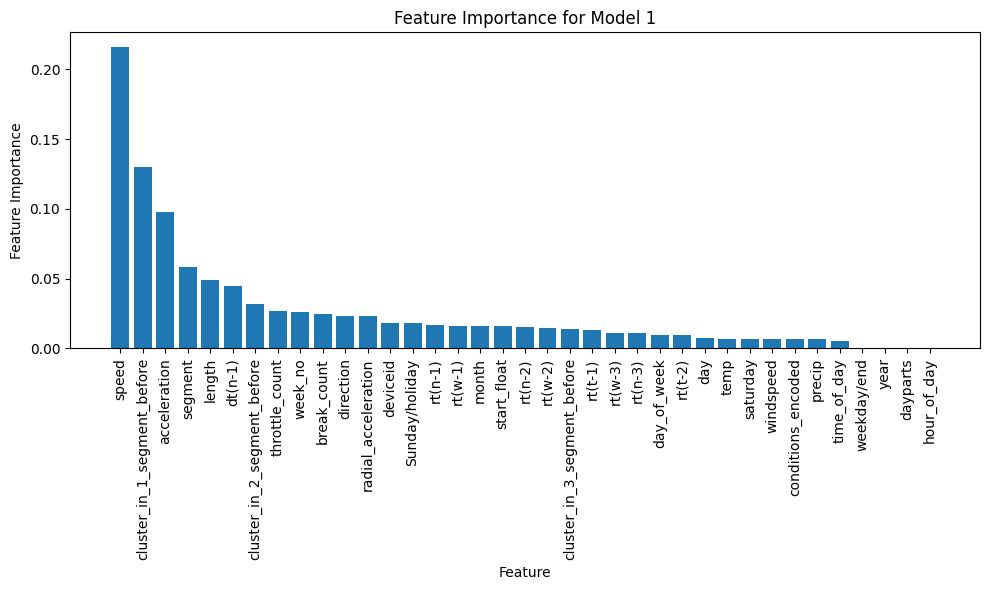

In [45]:
import matplotlib.pyplot as plt

# Get feature importances for Model 1
feature_importance1 = xgb.feature_importances_

# Get the names of the features
feature_names1 = X_train.columns

# Sort feature importances and feature names in descending order
sorted_idx1 = feature_importance1.argsort()[::-1]
feature_importance1 = feature_importance1[sorted_idx1]
feature_names1 = feature_names1[sorted_idx1]

# Create a bar graph for Model 1
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance1)), feature_importance1, align='center')
plt.xticks(range(len(feature_importance1)), feature_names1, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Model 1')
plt.tight_layout()
plt.show()


In [46]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import scipy.stats

# Define the hyperparameters grid with a broader range of values
param_dist = {
    'n_estimators': scipy.stats.randint(100, 1000),
    'max_depth': scipy.stats.randint(3, 15),
    'learning_rate': scipy.stats.uniform(0.01, 0.3),
    'subsample': scipy.stats.uniform(0.6, 0.4),  # Range for subsample
    'colsample_bytree': scipy.stats.uniform(0.6, 0.4),  # Range for colsample_bytree
    'gamma': scipy.stats.uniform(0, 5),  # Range for gamma
    'min_child_weight': scipy.stats.randint(1, 10),
    # Add other hyperparameters you want to tune
}

# Create the XGBoost classifier
xgb = XGBClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=3,
    n_jobs=13,
    n_iter=150,  # Number of random parameter combinations to try
    verbose=2
)

# Perform the randomized search
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Evaluate the model with the best parameters
best_xgb = random_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

print("Best XGBoost Accuracy:", accuracy_best)
print("Best XGBoost Classification Report:\n", report_best)


Fitting 3 folds for each of 150 candidates, totalling 450 fits
Best Hyperparameters: {'colsample_bytree': 0.7847289880846788, 'gamma': 2.9937152546853643, 'learning_rate': 0.023897343363201786, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 302, 'subsample': 0.8783408913178221}
Best XGBoost Accuracy: 0.5844737798231804
Best XGBoost Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.73      0.63      8991
         1.0       0.69      0.38      0.49      8482
         2.0       0.57      0.65      0.61      7298

    accuracy                           0.58     24771
   macro avg       0.60      0.58      0.57     24771
weighted avg       0.61      0.58      0.57     24771



In [47]:
# from sklearn.model_selection import GridSearchCV

# # Define the hyperparameters grid
# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 300, 500],
#     # Add other hyperparameters you want to tune
# }

# # Create the XGBoost classifier
# xgb = XGBClassifier()

# # Create the GridSearchCV object
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# # Perform the grid search
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)


In [48]:
y_train

0         2.0
1         2.0
2         2.0
3         1.0
4         1.0
         ... 
181846    2.0
181847    2.0
181848    2.0
181849    2.0
181850    2.0
Name: norm_cluster, Length: 169094, dtype: float64

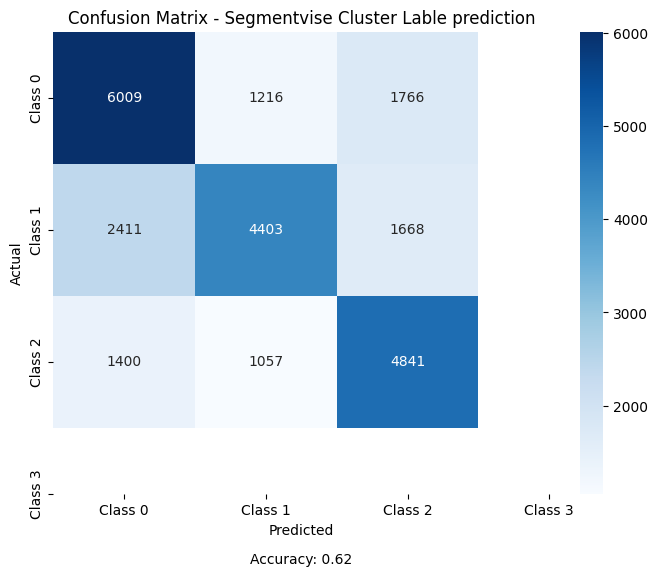

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test contains actual labels and y_pred contains predicted labels
confusion = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2','Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2','Class 3'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Segmentvise Cluster Lable prediction')

# Annotate the accuracy value at the bottom of the graph
plt.annotate(f'Accuracy: {accuracy:.2f}', (0.5, -0.15), xycoords='axes fraction', ha='center')

plt.show()


In [50]:
# from test_ data drop the Kmeans_cluster column and rename the Predicted_Kmeans_cluster column to Kmeans_cluster
test_data.drop('norm_cluster',axis=1,inplace=True)
test_data.rename(columns={'Predicted_Kmeans_cluster':'norm_cluster'},inplace=True)

In [51]:
# concatanate train_data and test_data
bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test = pd.concat([train_data,test_data])
bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count,cluster_in_1_segment_before,cluster_in_2_segment_before,cluster_in_3_segment_before
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,2.0,2021,4.0,6.663611,0,6.551622,-0.263065,0.289582,1.333333,0.333333,NaN,NaN,NaN
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,2.0,2021,4.0,6.703333,0,10.318498,-0.020071,0.876211,3.000000,1.000000,2.0,NaN,NaN
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,2.0,2021,4.0,6.761667,0,9.510959,-0.306166,0.668537,7.500000,8.250000,2.0,2.0,NaN
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,1.0,2021,4.0,6.901111,0,12.014774,-0.072601,0.425698,3.250000,3.750000,2.0,2.0,2.0
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,1.0,2021,4.0,6.955278,0,14.626720,-0.645813,0.374014,1.250000,1.000000,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193860,3462.0,123.0,2.0,28.0,99.0,0.8700,0.0,18.75,0.0,0,1,42.0,120.0,120.0,120.0,120.0,120.0,63.0,156.0,197.0,18.0,31,10,22.2,0.0,4.3,9.0,0.0,2022,4.0,18.762222,1,9.194479,-0.351201,0.519947,2.371622,2.594595,0.0,1.0,2.0
193861,3462.0,123.0,2.0,29.0,165.0,1.4000,0.0,18.75,0.0,0,1,42.0,218.0,218.0,218.0,218.0,218.0,99.0,63.0,156.0,18.0,31,10,22.2,0.0,4.3,15.0,0.0,2022,4.0,18.793889,1,10.303061,-0.349294,0.602160,4.045558,4.482916,1.0,0.0,1.0
193862,3462.0,123.0,2.0,30.0,337.0,2.5600,0.0,18.75,0.0,0,1,42.0,391.0,391.0,391.0,391.0,391.0,165.0,99.0,63.0,18.0,31,10,22.2,0.0,4.3,33.0,0.0,2022,4.0,18.848889,1,9.094664,-0.193578,0.292496,9.096998,9.775982,1.0,1.0,0.0
193863,3462.0,123.0,2.0,31.0,46.0,0.4200,0.0,18.75,0.0,0,1,42.0,65.0,65.0,65.0,65.0,65.0,337.0,165.0,99.0,18.0,31,10,22.2,0.0,4.3,15.0,2.0,2022,4.0,18.946667,1,9.831210,-0.159683,0.266565,0.619048,1.043084,2.0,1.0,1.0


In [52]:
# save bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test to a csv
bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test.to_csv('../DataOut/bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test_normway.csv',index=False)